In [19]:
import numpy as np
from PIL import Image, ImageOps
import math
import random

In [43]:
screen_width = 1500
screen_height = 1500
scale = 8000
offset_x = screen_width/2
offset_y = 350
color = (147, 112, 219)

In [21]:
def bar_coord(x, y, x0, y0, x1, y1, x2 ,y2):
    denominator = (x0 - x2) * (y1 - y2) - (x1 - x2) * (y0 - y2)
    if abs(denominator) < 1e-10: 
        print("123")
        return (-1, -1, -1)

    lambda0 = ((x - x2) * (y1 - y2) - (x1 - x2) * (y - y2)) / denominator
    lambda1 = ((x0 - x2) * (y - y2) - (x - x2) * (y0 - y2)) / denominator
    lambda2 = 1.0 - lambda0 - lambda1
    return(lambda0, lambda1, lambda2)

In [22]:
def draw_triangle(x0, y0, z0, x1, y1, z1, x2, y2, z2):
    xmin = max(0, int(min(screen_width, x0, x1, x2)))
    ymin = max(0, int(min(screen_height, y0, y1, y2)))
    xmax = min(screen_width, int(max(0, x0, x1, x2))) + 1
    ymax = min(screen_height, int(max(0, y0, y1, y2))) + 1
    for y in range(ymin, ymax):
        for x in range(xmin, xmax):
            l0, l1, l2 = bar_coord(x, y, x0, y0, x1, y1, x2, y2)
            if l0 >= 0 and l1 >= 0 and l2 >= 0:
                z = l0*z0 + l1*z1 + l2*z2
                if z > zbuffer[y][x]: 
                    continue
                else:
                    img_mat[y][x] = color
                    zbuffer[y][x] = z

In [23]:
def get_normal(x0, y0, z0, x1, y1, z1, x2, y2, z2):
    return np.cross((x1-x2, y1-y2, z1-z2), (x1-x0, y1-y0, z1-z0))

In [65]:
def get_cos(vec1, vec2):
    cos_angle = np.dot(vec1, vec2)/(np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return max(-1, min(0, cos_angle))

In [25]:
def get_vertex(vertex):
    x_temp = vertex[0] - rotation_offset[0]
    y_temp = vertex[1] - rotation_offset[1]
    z_temp = vertex[2] - rotation_offset[2]

    x_rot = x_temp*COS - z_temp*SIN
    z_rot = z_temp*COS + x_temp*SIN

    x = (x_rot + rotation_offset[0]) * scale + offset_x
    y = (y_temp + rotation_offset[1]) * scale + offset_y
    z = (z_rot + rotation_offset[2]) * scale
    return (x,y,z)

C:\Users\rogov\AppData\Local\Temp\ipykernel_6396\1682162115.py:39: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(img_mat, mode='RGB')


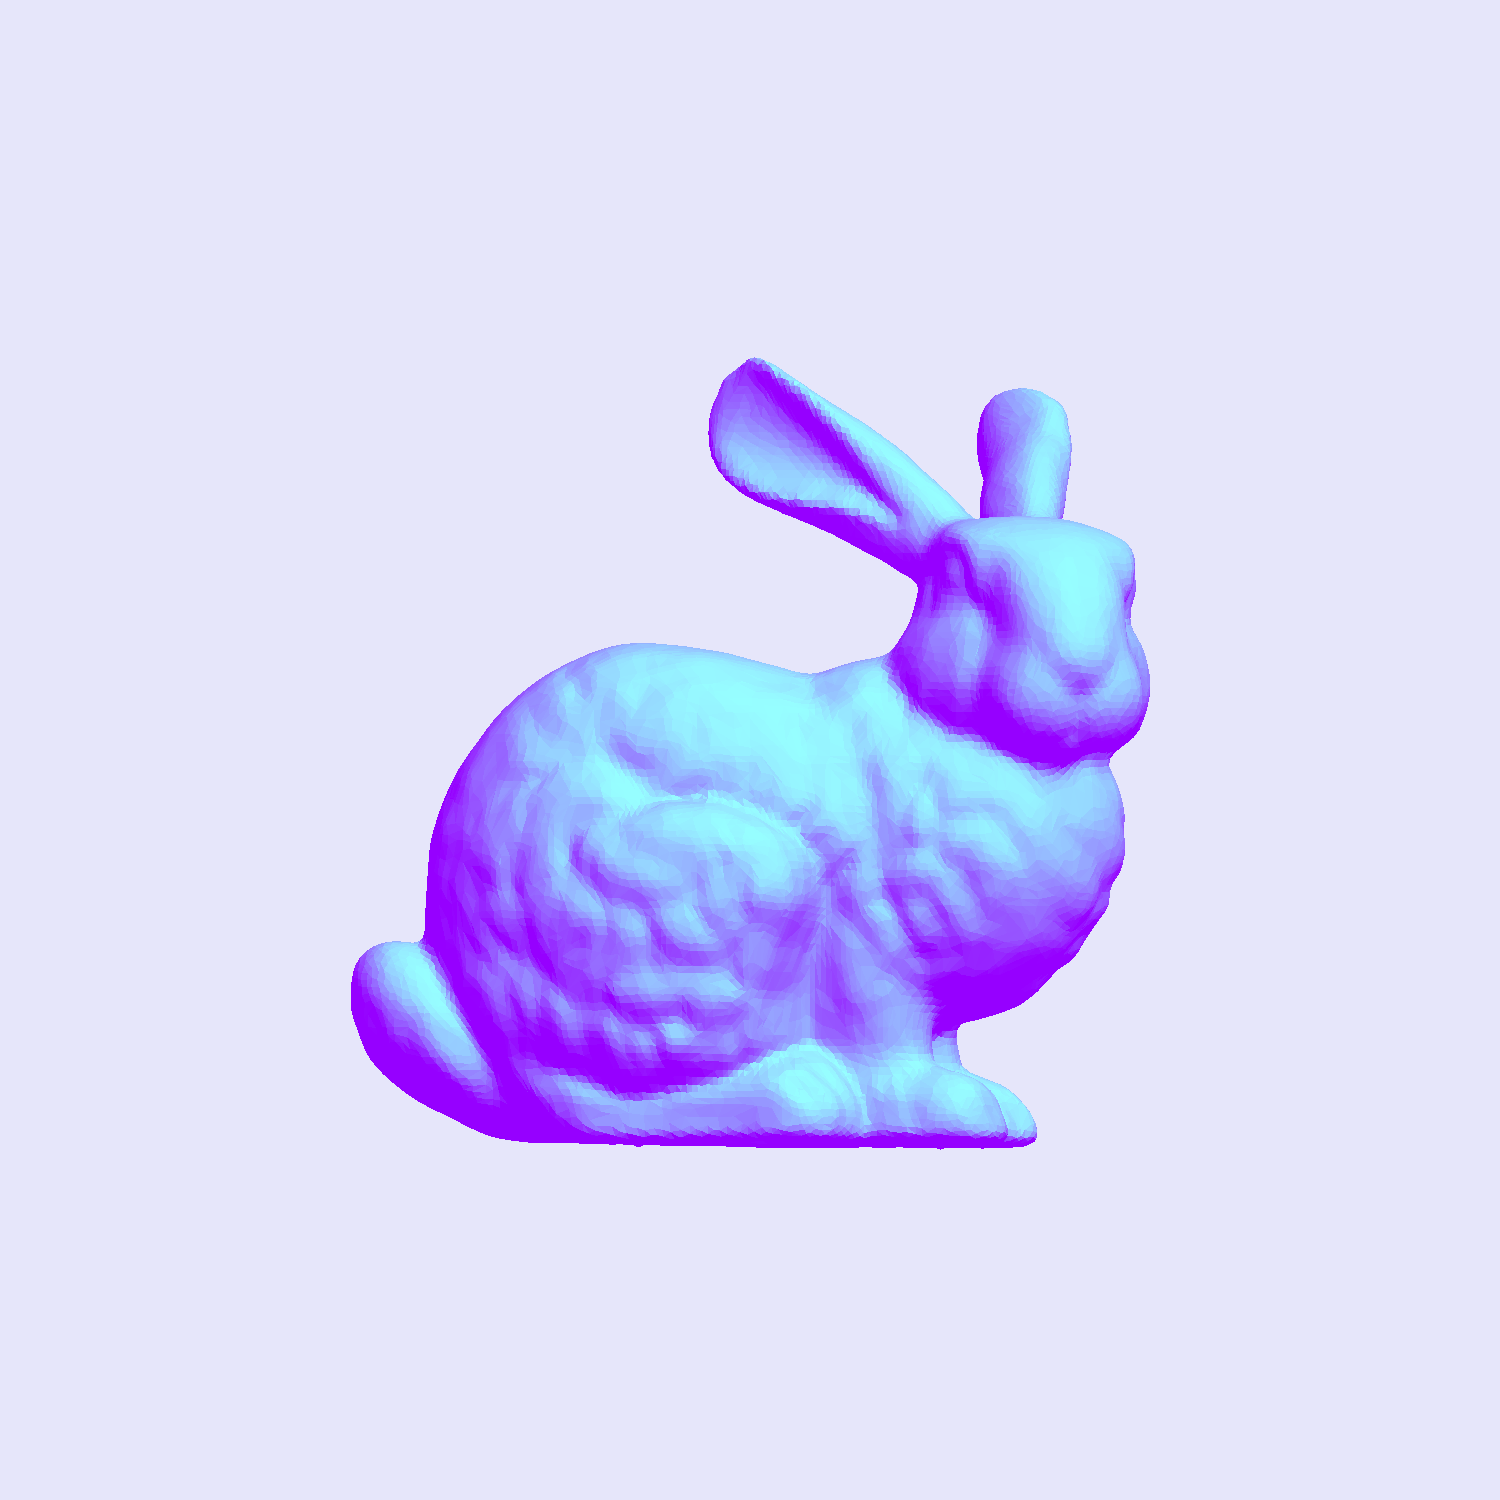

In [69]:
# Отрисовка 1 раз на заданный угол
img_mat = np.full((screen_height,screen_width,3), (230, 230, 250), dtype=np.uint8)
zbuffer = np.full((screen_height,screen_width), 100000)

file = open("assets/model_1.obj")
v = []
p = []
for s in file:
    sp = s.split(" ")
    if sp[0] == 'v':
        x, y, z = float(sp[1]), float(sp[2]), float(sp[3])
        v.append([x, y, z])
    if sp[0] == 'f':
        v1, v2, v3 = int(sp[1].split('/')[0]), int(sp[2].split('/')[0]), int(sp[3].split('/')[0])
        p.append([v1, v2, v3])

avg_x = sum(vertex[0] for vertex in v) / len(v)
avg_y = sum(vertex[1] for vertex in v) / len(v)
avg_z = sum(vertex[2] for vertex in v) / len(v)
rotation_offset = (0, avg_y, avg_z)

angle = math.radians(180)
COS = math.cos(angle)
SIN = math.sin(angle)

light = (-0.5, -1, 1)
camera = (0, 0, 1)

for k in range(len(p)):
    x0, y0, z0 = get_vertex(v[p[k][0]-1])
    x1, y1, z1 = get_vertex(v[p[k][1]-1])
    x2, y2, z2 = get_vertex(v[p[k][2]-1])
    normal = get_normal(x0, y0, z0, x1, y1, z1, x2, y2, z2)
    light_cos = get_cos(normal, light)
    camera_cos = get_cos(normal, camera)
    color = (150, int(-255 * light_cos), 255)
    if camera_cos < 0: draw_triangle(x0, y0, z0, x1, y1, z1, x2, y2, z2)

img = Image.fromarray(img_mat, mode='RGB')
img = ImageOps.flip(img)
display(img)

In [70]:
img.save("img.png")
img.show()

In [56]:
# Отрисовка на 360
for angle in range(360):
    img_mat = np.full((screen_height,screen_width,3), (230, 230, 250), dtype=np.uint8)
    zbuffer = np.full((screen_height,screen_width), 100000)
    
    rad = math.radians(angle)
    COS = math.cos(rad)
    SIN = math.sin(rad)

    for k in range(len(p)):
        x0, y0, z0 = get_vertex(v[p[k][0]-1])
        x1, y1, z1 = get_vertex(v[p[k][1]-1])
        x2, y2, z2 = get_vertex(v[p[k][2]-1])
        normal = get_normal(x0, y0, z0, x1, y1, z1, x2, y2, z2)
        cos = get_cos_aqquracy_light(normal)
        color = (150, int(-255 * cos), 255)
        if cos < 0: draw_triangle(x0, y0, z0, x1, y1, z1, x2, y2, z2)

    img = Image.fromarray(img_mat, mode='RGB')
    img = ImageOps.flip(img)
    img.save("imgs/{}.png".format(angle))

C:\Users\rogov\AppData\Local\Temp\ipykernel_6396\4040755585.py:19: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(img_mat, mode='RGB')
